# Master Thesis Notebook

## Setup

In [1]:
# Importation of the classes and methods associated
from classes import *

## GPR VWC Analysis

### Raw data

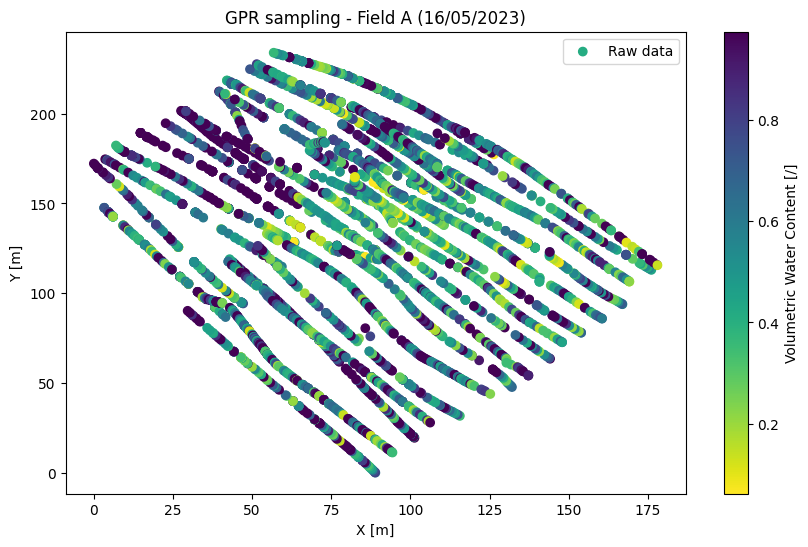

In [2]:
# Instance creation
gpr_a = GprAnalysis(field_letter="A", sample_number=0)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_a.plot_raw_data()

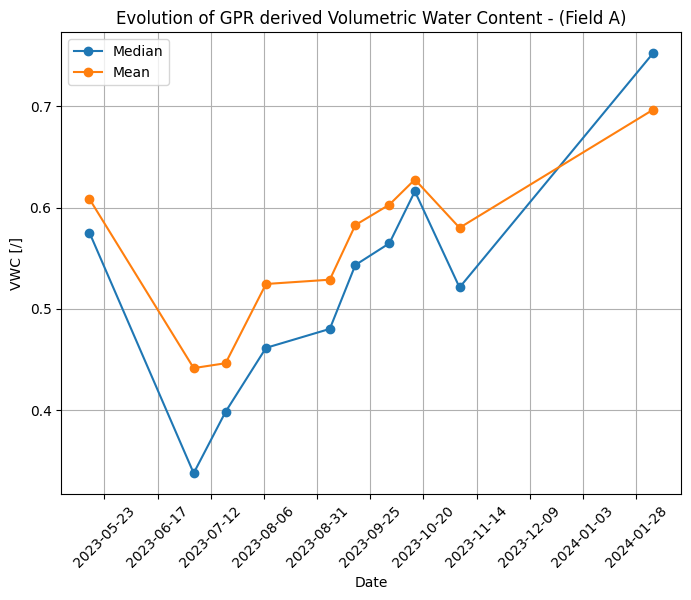

In [9]:
# Mean and median evolution (raw data)
gpr_a.plot_mean_median(plot=True)

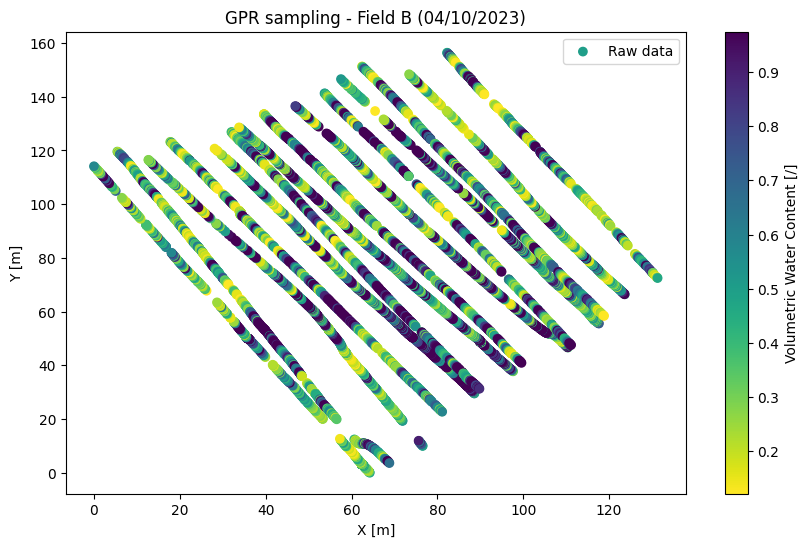

In [10]:
# Instance creation
gpr_b = GprAnalysis(field_letter="B", sample_number=6)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_b.plot_raw_data()

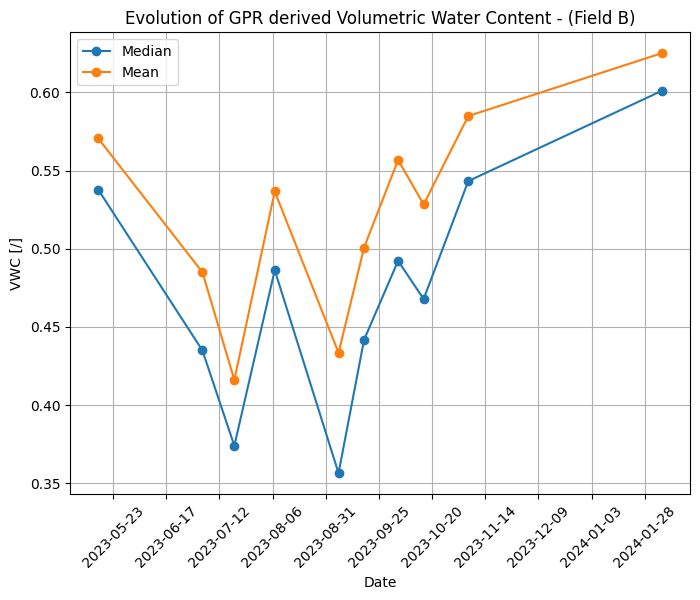

In [11]:
# Median evolution (raw data)
gpr_b.plot_mean_median(plot=True)

### Choosing the variogram model

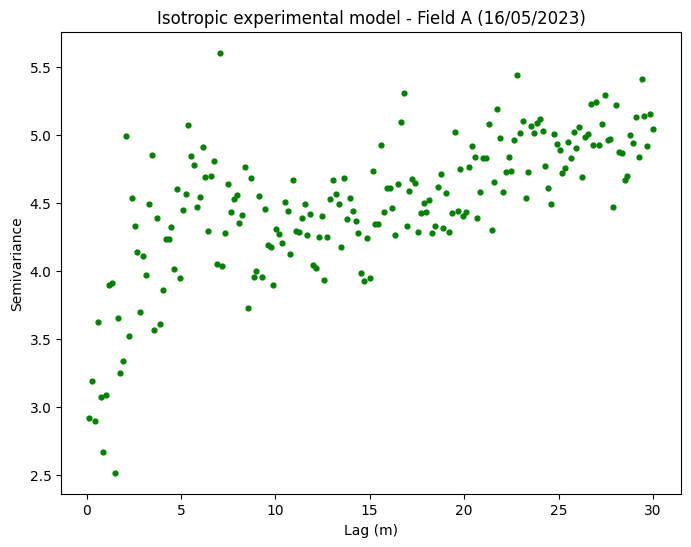

(< spherical Semivariogram fitted to 200 bins >,
 array([ 0.14999989,  0.29999979,  0.44999968,  0.59999957,  0.74999947,
         0.89999936,  1.04999926,  1.19999915,  1.34999904,  1.49999894,
         1.64999883,  1.79999872,  1.94999862,  2.09999851,  2.2499984 ,
         2.3999983 ,  2.54999819,  2.69999809,  2.84999798,  2.99999787,
         3.14999777,  3.29999766,  3.44999755,  3.59999745,  3.74999734,
         3.89999723,  4.04999713,  4.19999702,  4.34999692,  4.49999681,
         4.6499967 ,  4.7999966 ,  4.94999649,  5.09999638,  5.24999628,
         5.39999617,  5.54999606,  5.69999596,  5.84999585,  5.99999575,
         6.14999564,  6.29999553,  6.44999543,  6.59999532,  6.74999521,
         6.89999511,  7.049995  ,  7.19999489,  7.34999479,  7.49999468,
         7.64999458,  7.79999447,  7.94999436,  8.09999426,  8.24999415,
         8.39999404,  8.54999394,  8.69999383,  8.84999372,  8.99999362,
         9.14999351,  9.29999341,  9.4499933 ,  9.59999319,  9.74999309,
  

In [12]:
experimental_vario_a = Variogram(resolution=0.00002, field_letter="A", sample_number=0)

experimental_vario_a.determ_experimental_vario() ;
# ; hide output of the cell

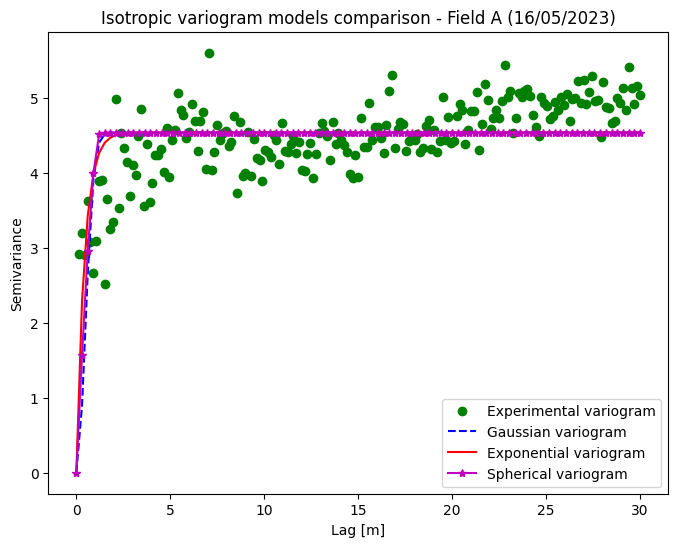

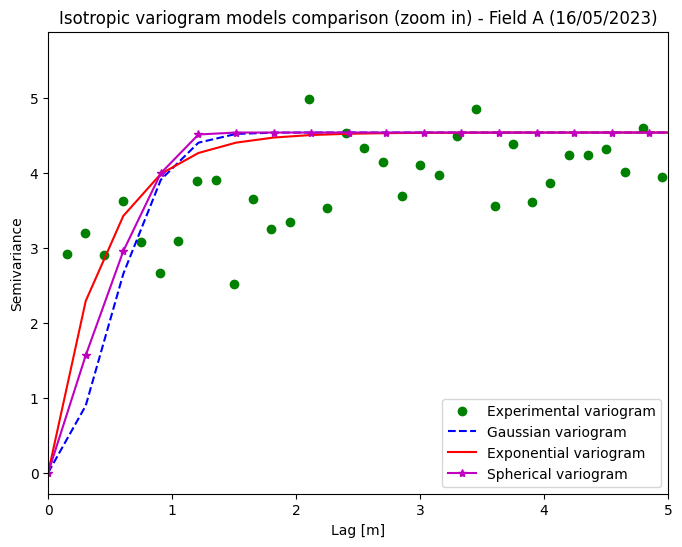

In [13]:
experimental_vario_a.fit_models()

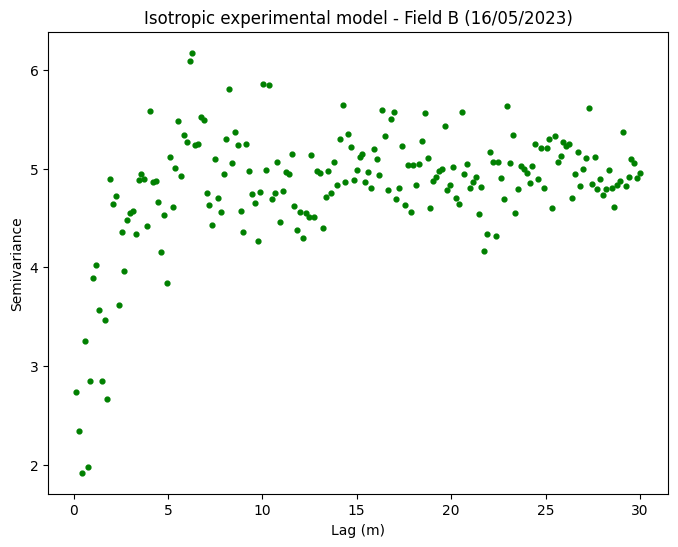

(< spherical Semivariogram fitted to 200 bins >,
 array([ 0.14999968,  0.29999935,  0.44999903,  0.59999871,  0.74999839,
         0.89999806,  1.04999774,  1.19999742,  1.34999709,  1.49999677,
         1.64999645,  1.79999612,  1.9499958 ,  2.09999548,  2.24999516,
         2.39999483,  2.54999451,  2.69999419,  2.84999386,  2.99999354,
         3.14999322,  3.2999929 ,  3.44999257,  3.59999225,  3.74999193,
         3.8999916 ,  4.04999128,  4.19999096,  4.34999064,  4.49999031,
         4.64998999,  4.79998967,  4.94998934,  5.09998902,  5.2499887 ,
         5.39998837,  5.54998805,  5.69998773,  5.84998741,  5.99998708,
         6.14998676,  6.29998644,  6.44998611,  6.59998579,  6.74998547,
         6.89998515,  7.04998482,  7.1999845 ,  7.34998418,  7.49998385,
         7.64998353,  7.79998321,  7.94998289,  8.09998256,  8.24998224,
         8.39998192,  8.54998159,  8.69998127,  8.84998095,  8.99998062,
         9.1499803 ,  9.29997998,  9.44997966,  9.59997933,  9.74997901,
  

In [14]:
experimental_vario_b = Variogram(resolution=0.00002, field_letter="B", sample_number=0)

experimental_vario_b.determ_experimental_vario()
# ; hide output of the cell

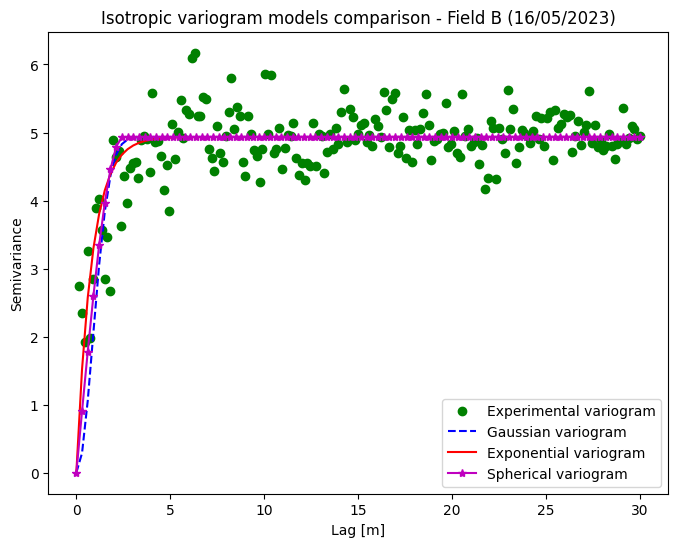

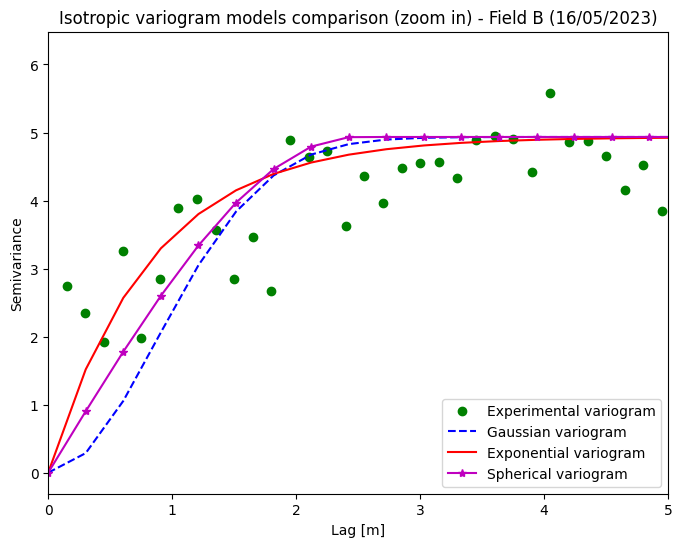

In [15]:
experimental_vario_b.fit_models()

### Kriged data

In [16]:
# gpr_a.kriging(plot=True)

In [17]:
# GprAnalysis(field_letter="A", sample_number=4).kriging(plot=True) # A/B # Sample number [0-9]

In [18]:
# GprAnalysis(field_letter="A", sample_number=0).kriging(plot=True) # A/B # Sample number [0-9]

In [19]:
# gpr_b.kriging(plot=True)

## TDR Verification

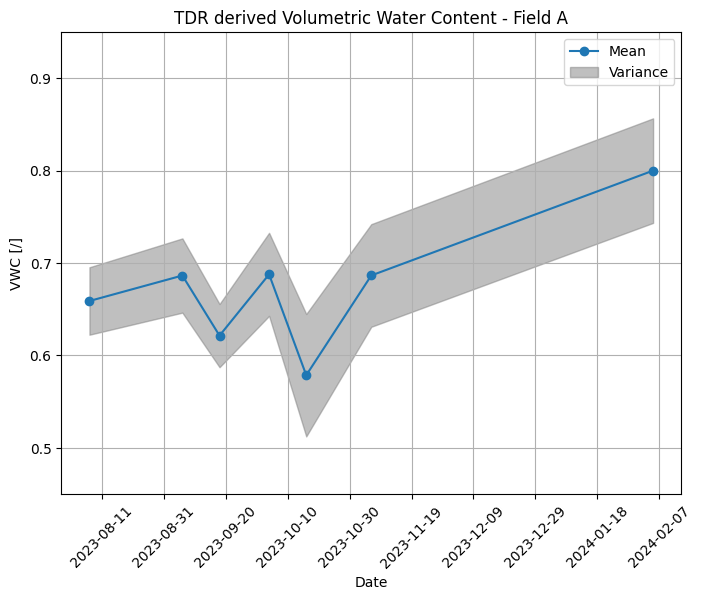

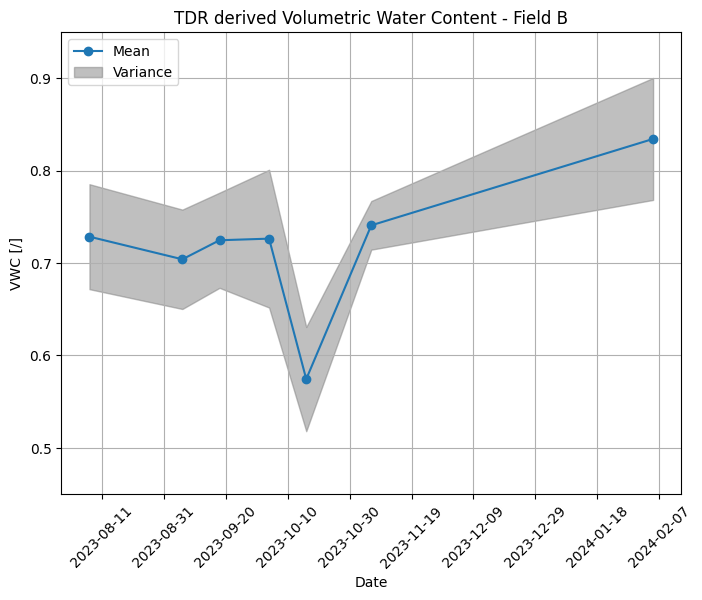

In [2]:
tdr_verif = TdrAnalysis()
tdr_verif.plot_tdr_evolution()

## Rainfall Analysis

d:\VScode\Master-Thesis\classes.py:605: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


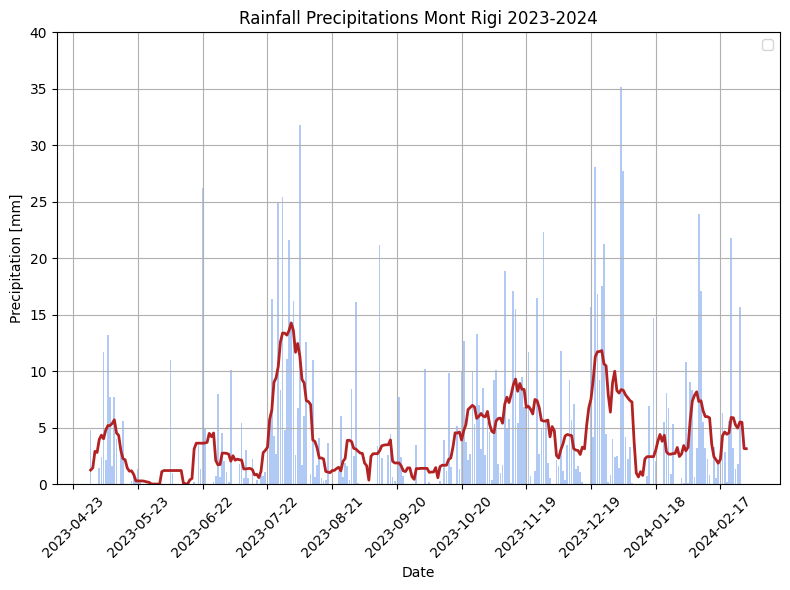

In [3]:
rf_mr = Rainfall()
rf_mr.plot_data()

## Multispectral analysis

### TVDI

The formula used for the Temperature Vegetation Dryness Index (TVDI) calculation is:

$$ \text{TVDI} = \frac{\text{LST} - T_{\text{min}}(\text{NDVI})}{T_{\text{max}}(\text{NDVI}) - T_{\text{min}}(\text{NDVI})} $$

Where:
- LST is the Land Surface Temperature for a given pixel.
- T max NDVI is the maximum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{max}}(\text{NDVI}) = a \cdot \text{NDVI} + b $$
- T min NDVI is the minimum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{min}}(\text{NDVI}) = c \cdot \text{NDVI} + d $$

Here the specific linear functions used were:

$$ T_{\text{max}}(\text{NDVI}) = 40 \cdot \text{NDVI} + 300 $$

$$ T_{\text{min}}(\text{NDVI}) = 20 \cdot \text{NDVI} + 250 $$


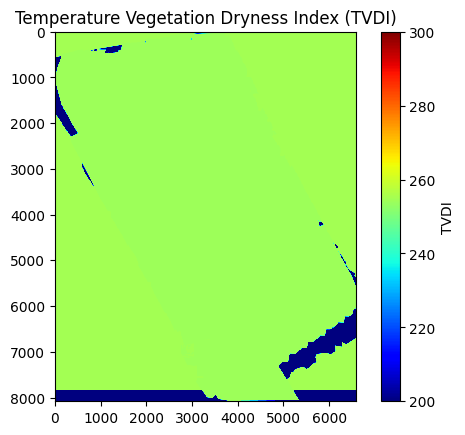

In [2]:
multi_a = MultispecAnalysis(
    temperature_raster=MultispecAnalysis.TEMPERATURE_RASTER, ndvi_raster=MultispecAnalysis.NDVI_RASTER
)

multi_a.calculate_tvdi()